# Clasificador KNN

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets
datasets = {
    "healthcare": ("Dataset\\healthcare_dataset.csv"),
    "bank": "Dataset\\bank_full.csv",
    "credit": "Dataset\\default_credit_card_clients.csv"
}

# Preprocesamiento
def preprocess_data(df, dataset_name):
    # Codificar variables categóricas
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

    # Manejar valores faltantes (imputación simple por la media - se puede mejorar)
    for col in df.columns:
        if df[col].dtype != 'object':
            df[col] = df[col].fillna(df[col].mean())


    if dataset_name == 'credit':
        df = df.drop('ID', axis=1)  # Eliminar ID

    return df

# Validación y evaluación
def evaluate_knn(X, y, k=5):
    results = {}

    # Hold-out 70/30 estratificado
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results["hold_out"] = {"accuracy": accuracy_score(y_test, y_pred), "confusion_matrix": confusion_matrix(y_test, y_pred)}

    # 10-Fold Cross-Validation estratificado
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    accuracies = []
    cms = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        cms.append(confusion_matrix(y_test, y_pred))
    results["10_fold"] = {"accuracy": np.mean(accuracies), "confusion_matrix": np.sum(cms, axis=0)} #Matriz de confusión agregada

    # Leave-One-Out
    loo = LeaveOneOut()
    accuracies = []
    cms = [] # Inicializar lista para matrices de confusión
    for train_index, test_index in loo.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        cms.append(confusion_matrix(y_test, y_pred))

    results["loo"] = {"accuracy": np.mean(accuracies), "confusion_matrix": np.sum(cms, axis=0)}

    return results


# Bucle principal
for dataset_name, file_path in datasets.items():
    print(f"Procesando dataset: {dataset_name}")
    try:
        df = pd.read_csv(file_path)
        df = preprocess_data(df, dataset_name)

        # Definir la columna objetivo
        if dataset_name == "healthcare":
            target_column = "Medical Condition"
        elif dataset_name == "bank":
            target_column = 'y'
        elif dataset_name == "credit":
            target_column = 'default payment next month'

        X = df.drop(target_column, axis=1).values
        y = df[target_column].values

        # Escalar datos (importante para KNN)
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Encontrar el mejor K (ejemplo con validación cruzada)
        k_values = range(1, 31)  # Probar valores de K del 1 al 30
        cv_scores = []
        for k in k_values:
            results = evaluate_knn(X, y, k)
            cv_scores.append(results['10_fold']['accuracy'])

        best_k = k_values[np.argmax(cv_scores)]
        print(f"Mejor K: {best_k}")


        # Evaluar con el mejor K
        results = evaluate_knn(X, y, best_k)

        for method, metrics in results.items():
            print(f"\tMétodo: {method}")
            print(f"\t\tAccuracy: {metrics['accuracy']}")
            print(f"\t\tMatriz de Confusión:\n{metrics['confusion_matrix']}")
            # Visualizar la matriz de confusión
            plt.figure(figsize=(6, 4))
            sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
            plt.title(f'Matriz de Confusión ({method.capitalize()}) - {dataset_name}')
            plt.ylabel('Verdadero')
            plt.xlabel('Predicción')
            plt.show()


    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_path}")
    except Exception as e:
        print(f"Error al procesar {dataset_name}: {e}")

Procesando dataset: healthcare


c:\Users\kev_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\kev_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\kev_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\kev_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classificatio

KeyboardInterrupt: 


Analizando dataset Healthcare...

Dataset: Healthcare
Muestreando dataset de 55500 a 5000 muestras...
Número de muestras para Hold-Out y CV: 5000

Resultados Hold-Out (70/30):
K=3 - Accuracy: 0.3253
Matriz de confusión para K=3:
[[212 129 163]
 [216 148 132]
 [251 121 128]]
K=5 - Accuracy: 0.3247
Matriz de confusión para K=5:
[[197 165 142]
 [218 184  94]
 [228 166 106]]
K=7 - Accuracy: 0.3480
Matriz de confusión para K=7:
[[192 168 144]
 [185 185 126]
 [185 170 145]]
K=9 - Accuracy: 0.3273
Matriz de confusión para K=9:
[[189 155 160]
 [201 165 130]
 [222 141 137]]
K=11 - Accuracy: 0.3480
Matriz de confusión para K=11:
[[199 173 132]
 [182 198 116]
 [223 152 125]]

Resultados 10-Fold Cross-Validation:
K=3 - Accuracy promedio: 0.3304
K=5 - Accuracy promedio: 0.3232
K=7 - Accuracy promedio: 0.3250
K=9 - Accuracy promedio: 0.3222
K=11 - Accuracy promedio: 0.3282
Muestreando dataset de 55500 a 1000 muestras...

Número de muestras para LOO: 1000

Resultados Leave-One-Out:
K=3 - Accuracy: 0

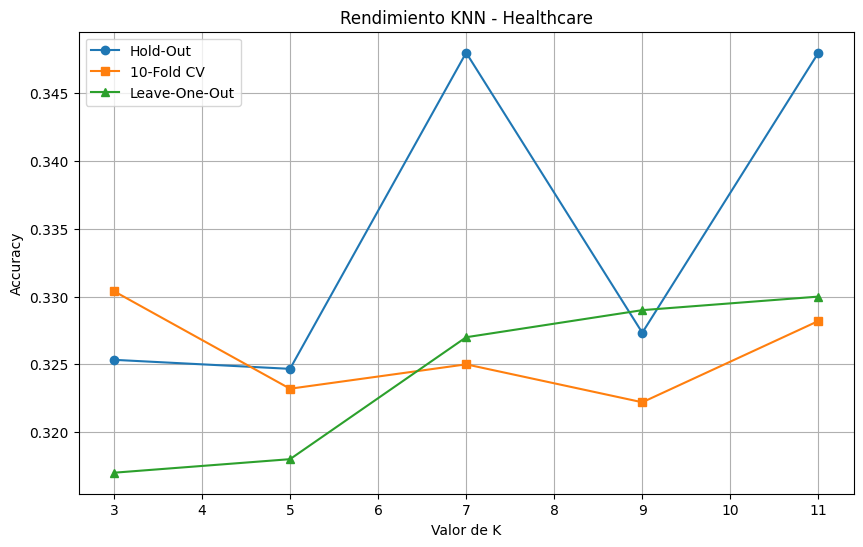


Mejor valor de K para Healthcare: 11
Accuracy promedio con K=11: 0.3354

Analizando dataset Bank...

Dataset: Bank
Muestreando dataset de 45211 a 5000 muestras...
Número de muestras para Hold-Out y CV: 5000

Resultados Hold-Out (70/30):
K=3 - Accuracy: 0.8913
Matriz de confusión para K=3:
[[1295   30]
 [ 133   42]]
K=5 - Accuracy: 0.8893
Matriz de confusión para K=5:
[[1304   21]
 [ 145   30]]
K=7 - Accuracy: 0.8887
Matriz de confusión para K=7:
[[1309   16]
 [ 151   24]]
K=9 - Accuracy: 0.8873
Matriz de confusión para K=9:
[[1311   14]
 [ 155   20]]
K=11 - Accuracy: 0.8887
Matriz de confusión para K=11:
[[1316    9]
 [ 158   17]]

Resultados 10-Fold Cross-Validation:
K=3 - Accuracy promedio: 0.8890
K=5 - Accuracy promedio: 0.8908
K=7 - Accuracy promedio: 0.8902
K=9 - Accuracy promedio: 0.8902
K=11 - Accuracy promedio: 0.8866
Muestreando dataset de 45211 a 1000 muestras...

Número de muestras para LOO: 1000

Resultados Leave-One-Out:
K=3 - Accuracy: 0.8800
K=5 - Accuracy: 0.8840
K=7 -

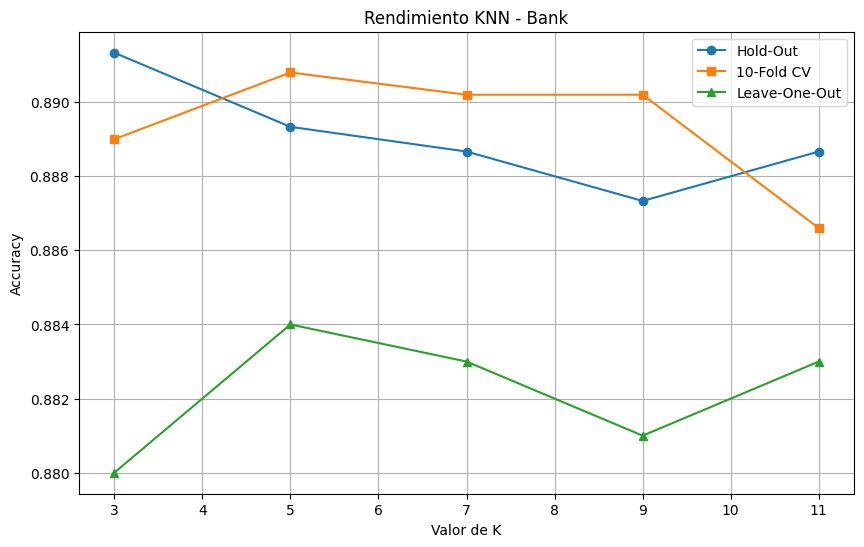


Mejor valor de K para Bank: 5
Accuracy promedio con K=5: 0.8880

Analizando dataset Credit Card...

Dataset: Credit Card
Muestreando dataset de 30000 a 5000 muestras...
Número de muestras para Hold-Out y CV: 5000

Resultados Hold-Out (70/30):
K=3 - Accuracy: 0.7533
Matriz de confusión para K=3:
[[1027  141]
 [ 229  103]]
K=5 - Accuracy: 0.7753
Matriz de confusión para K=5:
[[1060  108]
 [ 229  103]]
K=7 - Accuracy: 0.7900
Matriz de confusión para K=7:
[[1088   80]
 [ 235   97]]
K=9 - Accuracy: 0.8000
Matriz de confusión para K=9:
[[1103   65]
 [ 235   97]]
K=11 - Accuracy: 0.8013
Matriz de confusión para K=11:
[[1109   59]
 [ 239   93]]

Resultados 10-Fold Cross-Validation:
K=3 - Accuracy promedio: 0.7754
K=5 - Accuracy promedio: 0.7870
K=7 - Accuracy promedio: 0.7960
K=9 - Accuracy promedio: 0.8030
K=11 - Accuracy promedio: 0.8040
Muestreando dataset de 30000 a 1000 muestras...

Número de muestras para LOO: 1000

Resultados Leave-One-Out:
K=3 - Accuracy: 0.7580
K=5 - Accuracy: 0.7730

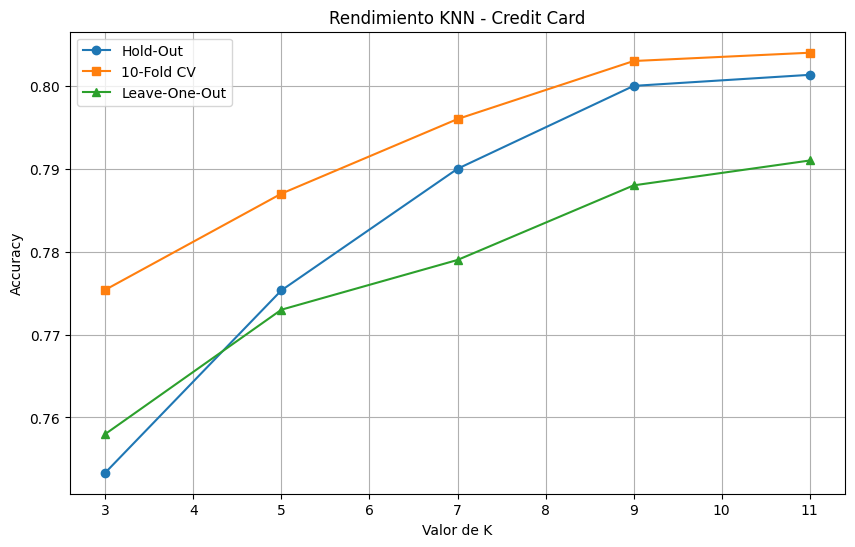


Mejor valor de K para Credit Card: 11
Accuracy promedio con K=11: 0.7988


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def sample_data(X, y, max_samples=5000, for_loo=False):
    """
    Muestrea los datos si exceden el número máximo de muestras.
    Mantiene la estratificación de las clases.

    Parameters:
    for_loo (bool): Si es True, usa un límite de 1000 muestras para LOO
    """
    limit = 1000 if for_loo else max_samples

    if len(X) > limit:
        print(f"Muestreando dataset de {len(X)} a {limit} muestras...")
        X_sampled, _, y_sampled, _ = train_test_split(
            X, y,
            train_size=limit,
            stratify=y,
            random_state=42
        )
        return X_sampled, y_sampled.reset_index(drop=True) # Reiniciar índices
    return X.reset_index(drop=True), y.reset_index(drop=True)

def prepare_healthcare_data():
    # Cargar dataset de healthcare
    df = pd.read_csv("Dataset\\healthcare_dataset.csv")
    
    # Preprocesar variables categóricas
    le = LabelEncoder()
    df['Gender'] = le.fit_transform(df['Gender'])
    df['Blood Type'] = le.fit_transform(df['Blood Type'])
    df['Medical Condition'] = le.fit_transform(df['Medical Condition'])
    df['Test Results'] = le.fit_transform(df['Test Results'])
    
    # Seleccionar features relevantes
    X = df[['Age', 'Gender', 'Blood Type', 'Medical Condition']]
    y = df['Test Results']
    
    return X, y

def prepare_bank_data():
    # Cargar dataset del banco
    df = pd.read_csv("Dataset\\bank_full.csv", sep=";")
    
    # Preprocesar variables categóricas
    categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
    le = LabelEncoder()
    for col in categorical_columns:
        df[col] = le.fit_transform(df[col])
    
    # Convertir variable objetivo
    df['y'] = (df['y'] == 'yes').astype(int)
    
    # Seleccionar features
    X = df.drop('y', axis=1)
    y = df['y']
    
    return X, y

def prepare_credit_data():
    # Cargar dataset de tarjetas de crédito
    df = pd.read_csv("Dataset\\default_credit_card_clients.csv")
    
    # Seleccionar features relevantes
    X = df.drop(['ID', 'default payment next month'], axis=1)
    y = df['default payment next month']
    
    return X, y

def evaluate_knn(X, y, dataset_name):
    print(f"\nDataset: {dataset_name}")

    # Muestrear datos para el análisis general
    X_sampled, y_sampled = sample_data(X, y)
    print(f"Número de muestras para Hold-Out y CV: {len(X_sampled)}")

    # Escalar features DESPUÉS del muestreo
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sampled)
    
    # 1. Hold-Out 70/30 estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_sampled, test_size=0.3, stratify=y_sampled, random_state=42
    )
    
    # Probar diferentes valores de K
    k_values = [3, 5, 7, 9, 11]
    holdout_scores = []
    
    print("\nResultados Hold-Out (70/30):")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        holdout_scores.append(score)
        print(f"K={k} - Accuracy: {score:.4f}")
        
        # Matriz de confusión
        y_pred = knn.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        print(f"Matriz de confusión para K={k}:")
        print(cm)
    
    # 2. 10-Fold Cross-Validation estratificado
    cv_scores = []
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    print("\nResultados 10-Fold Cross-Validation:")
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = []

        for train_index, val_index in skf.split(X_scaled, y_sampled):
            X_train_fold = X_scaled[train_index]
            X_val_fold = X_scaled[val_index]
            y_train_fold = y_sampled.iloc[train_index] # Usar .iloc
            y_val_fold = y_sampled.iloc[val_index]   # Usar .iloc

            knn.fit(X_train_fold, y_train_fold)
            score = knn.score(X_val_fold, y_val_fold)
            scores.append(score)

        cv_scores.append(np.mean(scores))
        print(f"K={k} - Accuracy promedio: {np.mean(scores):.4f}")

    # 3. Leave-One-Out con muestra reducida
    X_loo, y_loo = sample_data(X, y, for_loo=True)
    X_loo_scaled = scaler.fit_transform(X_loo) # Escalar después de muestrear para LOO
    print(f"\nNúmero de muestras para LOO: {len(X_loo)}")

    print("\nResultados Leave-One-Out:")
    loo = LeaveOneOut()
    loo_scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = []

        for train_index, test_index in loo.split(X_loo_scaled):
            X_train_loo = X_loo_scaled[train_index]
            X_test_loo = X_loo_scaled[test_index]
            y_train_loo = y_loo.iloc[train_index]  # Usar .iloc
            y_test_loo = y_loo.iloc[test_index]    # Usar .iloc

            knn.fit(X_train_loo, y_train_loo)
            score = knn.score(X_test_loo, y_test_loo)
            scores.append(score)

        loo_scores.append(np.mean(scores))
        print(f"K={k} - Accuracy: {np.mean(scores):.4f}")
    
    # Visualizar resultados
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, holdout_scores, marker='o', label='Hold-Out')
    plt.plot(k_values, cv_scores, marker='s', label='10-Fold CV')
    plt.plot(k_values, loo_scores, marker='^', label='Leave-One-Out')
    plt.xlabel('Valor de K')
    plt.ylabel('Accuracy')
    plt.title(f'Rendimiento KNN - {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Encontrar el mejor K
    methods = ['Hold-Out', '10-Fold CV', 'Leave-One-Out']
    scores = [holdout_scores, cv_scores, loo_scores]
    avg_scores = np.mean(scores, axis=0)
    best_k_index = np.argmax(avg_scores)
    best_k = k_values[best_k_index]
    
    print(f"\nMejor valor de K para {dataset_name}: {best_k}")
    print(f"Accuracy promedio con K={best_k}: {avg_scores[best_k_index]:.4f}")
    
    return holdout_scores, cv_scores, loo_scores

# Ejecutar análisis para cada dataset
datasets = [
    (prepare_healthcare_data(), 'Healthcare'),
    (prepare_bank_data(), 'Bank'),
    (prepare_credit_data(), 'Credit Card')
]

for (X, y), name in datasets:
    print(f"\nAnalizando dataset {name}...")
    evaluate_knn(X, y, name)